# EfficientNetB0 with custom layer



## Description

**Codabench accuracy** : 0.63

**Local test accuracy**: 0.96

**Description**: building a custom preprocessing layer that performs image thresholding to remove the backgrounds, both during prediction and testing.

The performance on Codabench remains roughly the same

**Motivation**: trying to implement custom layers to simplify the classification problem






## Google Drive - Connecting to the project

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1


## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
from tensorflow.keras.layers import Layer
tfkl = tfk.layers
import matplotlib.pyplot as plt

import cv2

from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Parameters

In [3]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)

## Load Data

In [4]:
# Cleaned dataset loading with a split in three datasets: training, validation, and test
X, y = utils.load_cleaned_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.2, val_size=0.2)

## Model Implementation

### Custom Layer

In [5]:
# Definition of the custom layer that removes the image background
class BackgroundRemovalLayer(Layer):
    # Class constructor that initializes a  threshold
    def __init__(self, threshold, name="BackgroundRemoval"):
        super().__init__(name=name)
        self.threshold = threshold
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))

    # Method used to initialize layer variables
    def build(self, input_shape):
        pass # This is a stateless layer

    # Method used to modify the image
    def call(self, inputs):
        img = inputs.numpy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = cv2.threshold(gray, self.threshold, 255, cv2.THRESH_BINARY_INV)[1]
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel)
        masked = cv2.bitwise_and(img,img,mask=mask)
        return masked

    # Method to compute the output shape given the input one (in this case they are the same)
    def compute_output_shape(self, input_shape):
        return input_shape

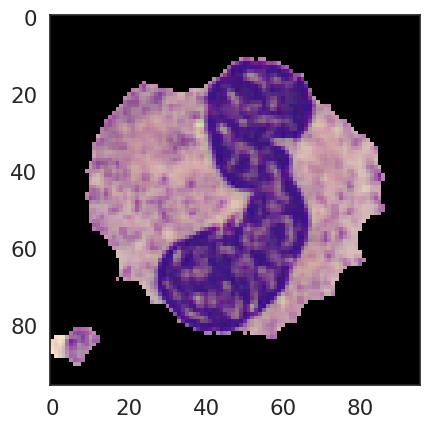

In [6]:
# Test on a single sample of the new layer
custom_layers = BackgroundRemovalLayer(threshold=155)
sample = X[3]
out = custom_layers(sample)

plt.imshow(out)
plt.show()

### Model

In [7]:
# Implementation of class balancing through weights for each class
CLASS_WEIGHTS = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
CLASS_WEIGHTS = {i:CLASS_WEIGHTS[i] for i in range(len(CLASS_WEIGHTS))}

In [8]:
# Importing of the model EfficientNetB0 without dense layers
efficientNet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
efficientNet.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Definition of the model
def build_model():
    # The input layer takes 96x96 RGB images
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Implementation of the background remover layer between the input layer and EfficientNetB0's first layer
    x = BackgroundRemovalLayer(threshold=155, name="custom_layer")(input_layer)

    # Definition of augmentation layer used to modify the samples
    augmentation = tfk.Sequential([
        tfkl.RandomFlip('horizontal_and_vertical'),
        tfkl.RandomRotation(0.2),
        tfkl.RandomTranslation(0.2, 0.2),
        tfkl.RandomContrast(0.3)
    ])

    # Implementation of the augmentation layer between the input layer and EfficientNetB0's first layer
    x = augmentation(input_layer)
    x = efficientNet(x)

    # GAP, dropoutm and dense layers for the top of the network
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.Dropout(0.5)(x)

    # Dense layer as output
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', name='Output')(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [10]:
# Model contruction
model = build_model()

# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.SparseCategoricalCrossentropy(), #Sparse since we are not one-hot-encoding (no difference)
              metrics=['accuracy'])

# Print model details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,571 (16.08 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Training

In [11]:
# Parameters used for training
EPOCHS = 1000
BATCH_SIZE = 32
PATIENCE = 10

In [12]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
callbacks = [early_stopping]

In [13]:
# Actual training of the model with the given parameters
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    class_weight=CLASS_WEIGHTS,
                    validation_data=(X_val,y_val)).history

Epoch 1/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4257 - loss: 1.6136 - val_accuracy: 0.7676 - val_loss: 0.7018
Epoch 2/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6560 - loss: 0.9684 - val_accuracy: 0.7906 - val_loss: 0.6272
Epoch 3/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6939 - loss: 0.8828 - val_accuracy: 0.8035 - val_loss: 0.5784
Epoch 4/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7167 - loss: 0.7839 - val_accuracy: 0.8156 - val_loss: 0.5364
Epoch 5/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7295 - loss: 0.7644 - val_accuracy: 0.8144 - val_loss: 0.5418
Epoch 6/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7407 - loss: 0.7504 - val_accuracy: 0.8219 - val_loss: 0.5383
Epoch 7/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7351 - loss: 0.7207 - val_accuracy: 0.8127 - val_loss: 0.5416
Epoch 8/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7350 - los

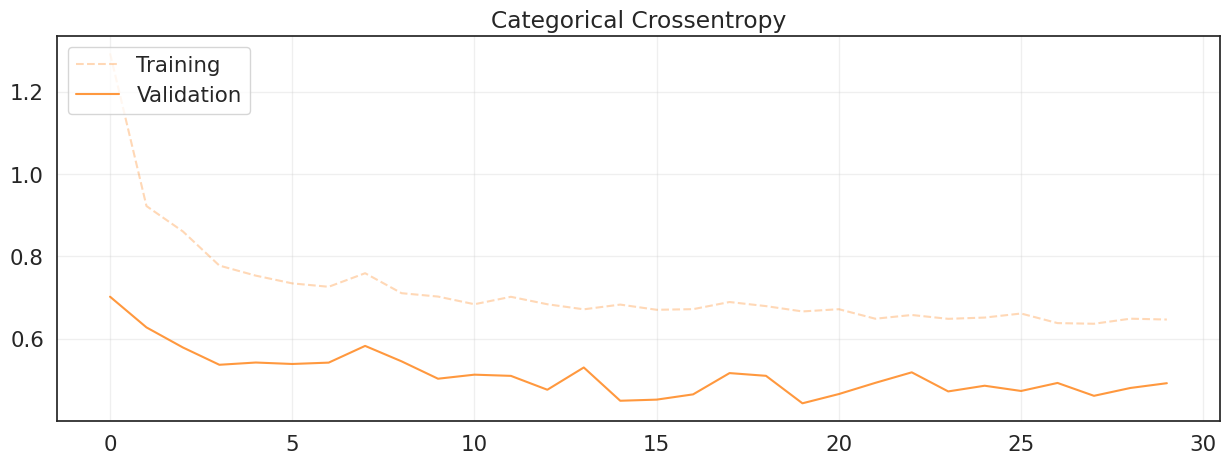

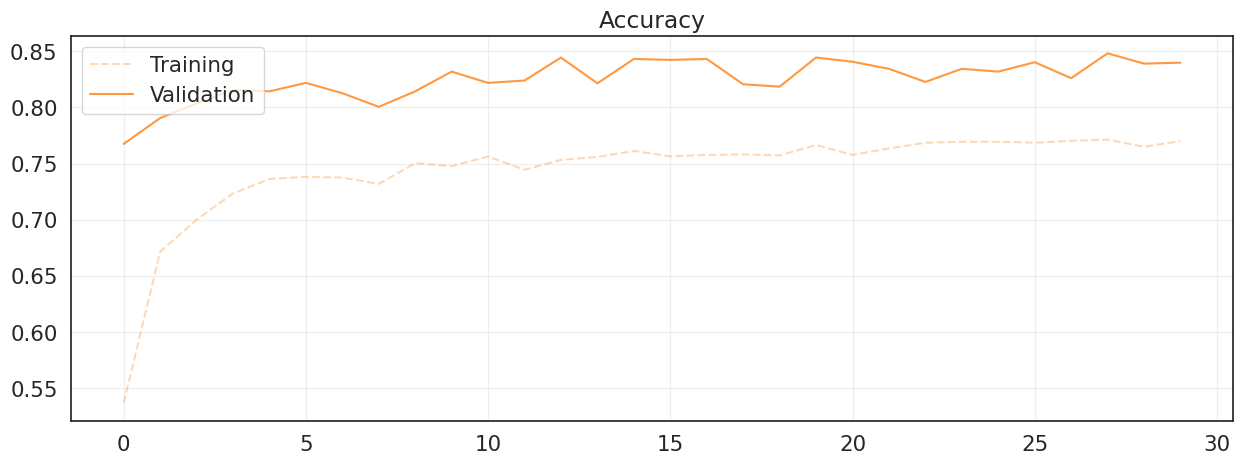

In [14]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(history)

## Save

In [15]:
# Saving the model for testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"efficientnetb0_custom_preprocess_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetb0_custom_preprocess_84.82.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Fine-Tuning


In [16]:
# Setting all the paramteres of the network as trainable
model.get_layer('efficientnetb0').trainable = True

# Setting some layers as not trainable since there is no necessity to train again all layers
for layer in model.get_layer('efficientnetb0').layers:
    layer.trainable = False

# Setting only Convolutional and GAP as trainable
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
    if isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.SeparableConv2D) or isinstance(layer, tfkl.DepthwiseConv2D):
        layer.trainable = True

# Setting a depth to which we freeze the training (0 to 162)
FREEZE_DEPTH = 162
for layer in model.get_layer('efficientnetb0').layers[:FREEZE_DEPTH]:
    layer.trainable = False

# Print model details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,544,573 (17.34 MB)

 Trainable params: 3,294,884 (12.57 MB)

 Non-trainable params: 919,687 (3.51 MB)

 Optimizer params: 330,002 (1.26 MB)

In [17]:
# Parameters used for Fine Tuning
FT_LEARNING_RATE = 1e-5

In [18]:
# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(optimizer=tfk.optimizers.Adam(FT_LEARNING_RATE),
                loss=tfk.losses.SparseCategoricalCrossentropy(), #Sparse since we are not one-hot-encoding (no difference)
                metrics=['accuracy'])

In [19]:
# Actual Fine Tuning of the model with the given parameters
finetuned_history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=(X_val,y_val)).history

Epoch 1/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.7804 - loss: 0.6123 - val_accuracy: 0.8370 - val_loss: 0.4575
Epoch 2/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.8104 - loss: 0.5417 - val_accuracy: 0.8537 - val_loss: 0.4163
Epoch 3/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8335 - loss: 0.4889 - val_accuracy: 0.8633 - val_loss: 0.3666
Epoch 4/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8359 - loss: 0.4820 - val_accuracy: 0.8683 - val_loss: 0.3676
Epoch 5/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8511 - loss: 0.4156 - val_accuracy: 0.8809 - val_loss: 0.3317
Epoch 6/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8542 - loss: 0.4283 - val_accuracy: 0.8712 - val_loss: 0.3542
Epoch 7/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8551 - loss: 0.4077 - val_accuracy: 0.8855 - val_loss: 0.3255
Epoch 8/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8669 - los

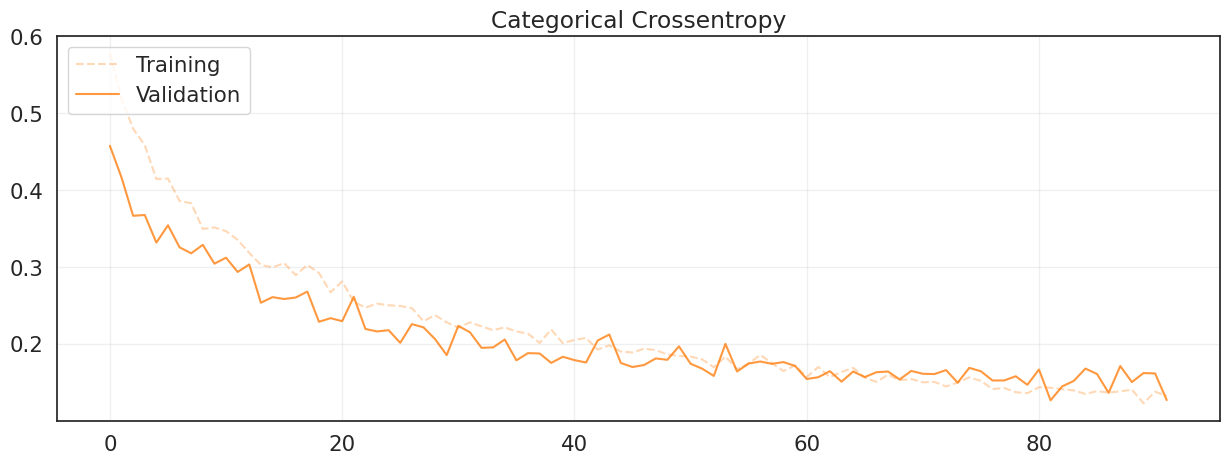

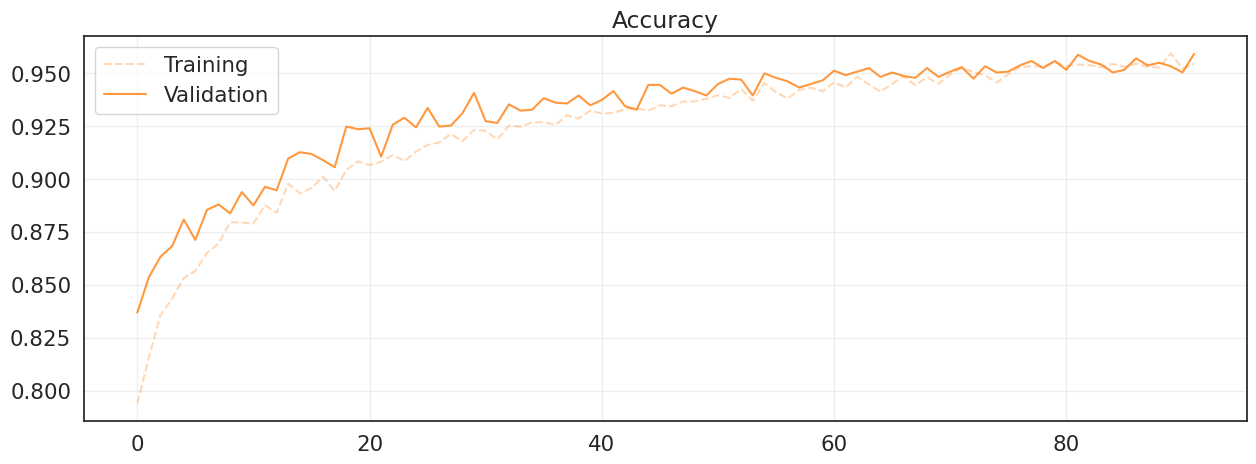

In [20]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(finetuned_history)

In [21]:
# Saving the model for testing and submission
accuracy = round(max(finetuned_history['val_accuracy'])* 100, 2)
model_name = f"efficientnetb0_custom_preprocess_ft_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetb0_custom_preprocess_ft_95.9.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [22]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [23]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.9599
Precision score over the test set: 0.9607
Recall score over the test set: 0.9599
F1 score over the test set: 0.9601
